# Comparing my implementations 

There is a MaxEnt toolbox in [matlab](https://github.com/orimaoz/maxent_toolbox) and I want to see whether the models I make using my code are the same as the models trained using the matlab toolbox.

## Read in Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit, prange
from math import comb

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Baskerville']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 14 

In [3]:
data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=int)

In [4]:
train = data[:10,:] # first 10 neurons outputs

In [5]:
N, M = train.shape
N, M

(10, 226814)

## Get expectations needed for models

### Avgs

In [6]:
avgs = np.mean(train,axis=1) # get the mean firing of neurons

In [7]:
avgs

array([0.02780693, 0.0081256 , 0.01418784, 0.01658628, 0.02141843,
       0.02126412, 0.02441648, 0.08030809, 0.04152742, 0.00597847])

### Correlations

In [8]:
@njit(parallel=True)
def correlations(arr):
    N, M = arr.shape
    corrs = np.zeros((N,N))
    for i in prange(N-1):
        for j in prange(i+1,N):
            corrs[i,j]=np.sum(arr[i]*arr[j])    
    return corrs / M

In [10]:
corr_mat = correlations(train) #correlation matrix
corrs = corr_mat[np.triu_indices_from(corr_mat,k=1)]

### P(K)

In [11]:
counts = np.sum(train,axis=0) # how many neurons fires in each bin
count_freq = np.bincount(counts) # tallies how many states with 0, 1, ... N neurons firing there are 
p_k = np.zeros(N+1)
for i in range(len(count_freq)): 
    p_k[i] = count_freq[i]/M 

In [12]:
np.max(counts), p_k

(5,
 array([7.90502350e-01, 1.67084042e-01, 3.40278819e-02, 7.15564295e-03,
        1.13749592e-03, 9.25868774e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

## Train models 

In [15]:
from maxent.coarse_models import Independent, PopCount
from maxent.numeric_ising import Ising

### Independent

In [16]:
indep = Independent(N, avgs) 

In [18]:
# compare to weights from matlab
mat_indep = np.loadtxt("../data/pop/indep.csv", delimiter=",", dtype=float)

In [19]:
def compare_weights(ours, theirs, title="Comparison of weights"):
    plt.figure(figsize=(6,6))
    min_max = [np.min([ours,theirs]),np.max([ours,theirs])]
    plt.plot(min_max,min_max, "--", color="gray",alpha=0.2)
    plt.plot(ours,theirs,".",color="black")
    plt.xlabel("Our weights")
    plt.ylabel("Maxent toolbox\n weights",rotation=0,labelpad=60)
    plt.title(title)
    plt.show()

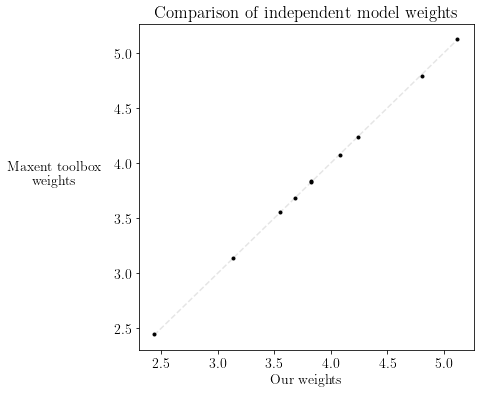

In [20]:
compare_weights(indep.h,mat_indep, "Comparison of independent model weights")

In [21]:
indep.h

array([3.55426931, 4.80457683, 4.2410808 , 4.0824542 , 3.82185233,
       3.8292407 , 3.68777737, 2.43816832, 3.13898705, 5.1135947 ])

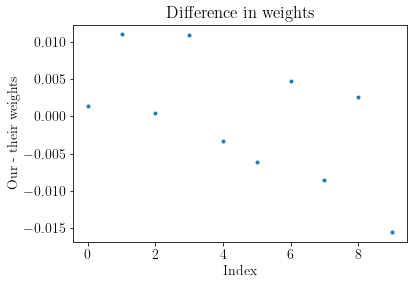

In [22]:
plt.plot(range(len(mat_indep)), indep.h-mat_indep,".")
plt.xlabel("Index")
plt.ylabel("Our - their weights")
plt.title("Difference in weights")
plt.show()

Compare the predicted distributions

In [23]:
def compare_dist(ours, theirs, xlab="Our model",ylab="Maxent toolbox",title="Comparison of probability of each state"):
    plt.figure(figsize=(6,6))
    min_max = [np.min([ours,theirs]),np.max([ours,theirs])]
    plt.plot(min_max,min_max, "--", color="gray",alpha=0.2)
    plt.loglog(ours,theirs,".",color="black")
    plt.xlabel(xlab)
    plt.ylabel(ylab,rotation=0,labelpad=60)
    plt.title(title)
    plt.show()

In [24]:
p_mat_states = np.loadtxt("../data/pop/indep_dist.csv", delimiter=",", dtype=float) # their predicted prob. of each state
p_states = indep.p(indep.states)  # use our model to predict the probability of each state 
p_flip_states = indep.p(np.flip(indep.states, 1)) # use our model to predict states but flip their representations

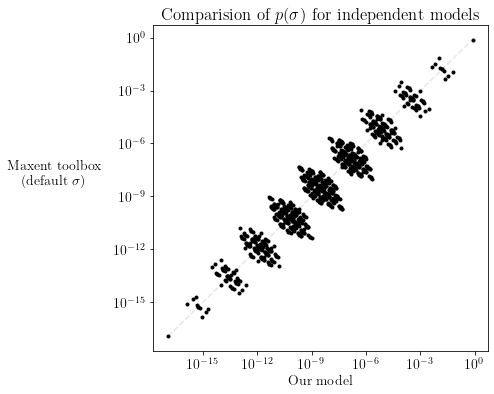

In [25]:
compare_dist(p_states,p_mat_states, ylab="Maxent toolbox\n (default $\sigma$)", title="Comparision of $p(\sigma)$ for independent models")

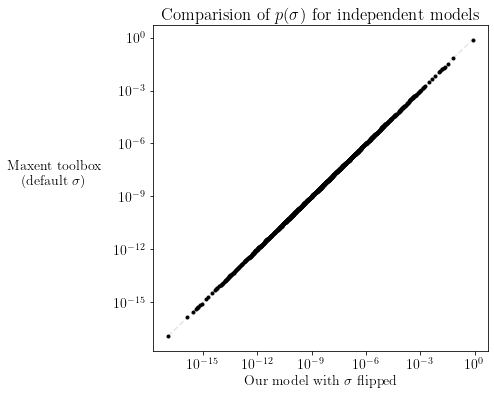

In [26]:
compare_dist(p_flip_states,p_mat_states, xlab="Our model with $\sigma$ flipped", ylab="Maxent toolbox\n (default $\sigma$)", title="Comparision of $p(\sigma)$ for independent models")

## P(K)
We get very different values for the model parameters for this model. This is because our parameters are just the observed $p(K)$, whereas they consider the potentials $V(K)$. We map between these below. 

In [27]:
pop = PopCount(N,p_k)

In [28]:
pop.p_K

array([7.90502350e-01, 1.67084042e-01, 3.40278819e-02, 7.15564295e-03,
       1.13749592e-03, 9.25868774e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [29]:
combs = np.array([comb(N,K) for K in np.arange(N+1)])
V_k = -np.log(pop.p_K[:6]/combs[:6])

In [30]:
mat_pk = np.loadtxt("../data/pop/ksync.csv", delimiter=",", dtype=float)

The difference between `V_k` and `mat_pk` should be equal to the log of the partition function. We can calculate this as $\sum_K \exp (-V_K)\cdot {N \choose K}$

In [31]:
mat_pk[:6]- V_k

array([-11.11141292, -11.10878053, -11.10748435, -11.11332012,
       -11.10137042, -10.9936522 ])

In [32]:
Z = np.sum(np.exp(-mat_pk)*combs)
np.log(Z)

11.110881686575699

In [33]:
for K in range(N+1):
    print("P(K)=", np.exp(-mat_pk)[K]/Z*combs[K], pop.p_K[K])

P(K)= 0.7909224053217281 0.7905023499431252
P(K)= 0.16673334153956051 0.16708404243124322
P(K)= 0.03391247387239906 0.034027881876780096
P(K)= 0.0071731128184065315 0.007155642949729734
P(K)= 0.0011267281875987332 0.0011374959217684976
P(K)= 8.234501592651241e-05 9.25868773532498e-05
P(K)= 1.1343425745118349e-05 0.0
P(K)= 1.0236951682100818e-05 0.0
P(K)= 1.0271624324961279e-05 0.0
P(K)= 1.0497332083652326e-05 0.0
P(K)= 7.2439105450143985e-06 0.0


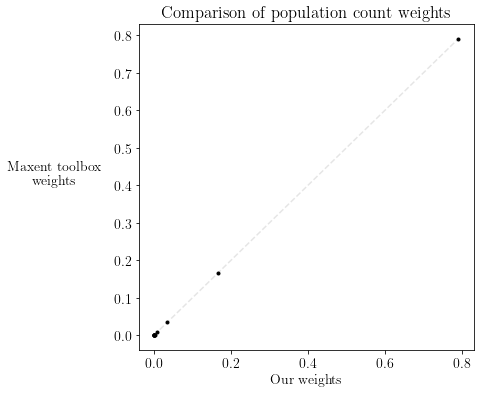

In [34]:
compare_weights(pop.p_K, np.exp(-mat_pk)*combs/Z,"Comparison of population count weights")

In [36]:
mat_states = np.loadtxt("../data/pop/ksync_dist.csv", delimiter=",", dtype=float)
p_states = pop.p(pop.states)

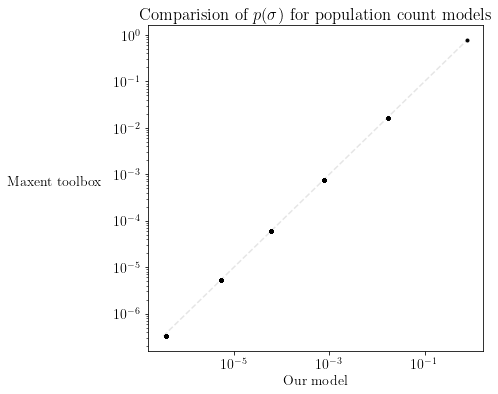

In [37]:
compare_dist(p_states[p_states>0],mat_states[p_states>0], title="Comparision of $p(\sigma)$ for population count models")

### Pairwise model

In [34]:
ising = Ising(N, avgs, corr_mat, lr=0.5) 

In [35]:
ising.lr=15

In [55]:
ising.gradient_ascent() # 500 steps 
corr_diff =  ising.correlations() - corr_mat
flat_corr = corr_diff[np.triu_indices_from(corr_diff,1)]
print("Difference in averages:", ising.averages() - avgs, "Difference in correlations:", flat_corr, sep="\n")

Difference in averages:
[-2.09221463e-10  1.29587884e-08 -7.18050020e-10  2.44819557e-10
 -3.12374709e-10  1.35879218e-10  1.42438610e-10  2.18595975e-12
  8.91809682e-11  1.48360404e-08]
Difference in correlations:
[ 1.38141269e-08 -4.31225842e-10 -1.06814045e-10 -4.74862559e-10
  1.03875404e-10  1.92953516e-10 -7.66104472e-11  1.14262037e-10
  8.98324178e-09  4.71654989e-08 -9.85762102e-09 -4.94509655e-09
 -1.82750635e-09 -2.31714996e-08 -7.59786293e-09 -6.35102759e-09
 -2.24151325e-06 -2.16401829e-10 -1.74742495e-09  1.62001269e-10
  6.33779583e-10 -4.25206511e-10  5.23480987e-10  1.41002790e-08
  3.44148858e-10 -1.45054224e-10  2.13562273e-10  4.66257566e-11
 -9.56683449e-11 -5.52649596e-08  4.40400273e-11  3.72066981e-10
  3.07209050e-10  1.60044471e-10  7.84024021e-08  7.70512998e-11
 -5.71242116e-11 -6.44308540e-11 -2.47491558e-08  7.42956820e-11
 -8.72561540e-11 -1.31939892e-08  6.28173208e-12  1.90996566e-08
 -1.39690849e-08]


Compare local fields:

In [56]:
ising.h

array([3.75351885, 4.95245782, 4.65326083, 4.14218959, 4.53338534,
       4.10001694, 3.79158359, 2.65777947, 3.21957838, 5.11512   ])

In [57]:
mat_ising = np.loadtxt("../data/pop/m_pwise.csv", delimiter=",", dtype=float)

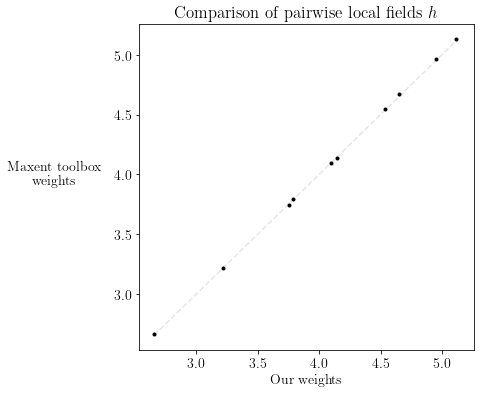

In [58]:
compare_weights(ising.h,mat_ising[:N],"Comparison of pairwise local fields $h$")

In [59]:
ising.J

array([[ 0.        , -0.36196264, -1.57802787,  0.85194289, -1.04041783,
        -0.10221599, -0.31015389, -0.75629573,  0.21176673, -0.69330977],
       [ 0.        ,  0.        , -0.50584702, -0.71572293, -1.05770114,
        -0.50421455,  0.68573359, -0.56611888,  0.28640748,  0.08192788],
       [ 0.        ,  0.        ,  0.        , -0.6048824 , -2.08961703,
        -0.48624579, -0.74682705, -0.53413385,  0.73228488, -1.5882105 ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.93667532,
        -0.62096332,  0.48078711, -0.38850508,  0.8124479 ,  0.8403782 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.25915905, -0.45313312, -1.97507958, -0.43756958,  0.2013129 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.73779614, -0.69778198,  0.32694945,  0.2139679 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.04575473

In [60]:
def flatten_corr(corr):
    N = len(corr)
    flat_corr = np.zeros(N*(N-1)//2)
    k = 0
    for i in range(N-1): # go through each row 
        for j in range(i+1,N): # go through each column
            flat_corr[k] = corr[i,j]
            k+=1
    return flat_corr

In [61]:
flat_J = flatten_corr(ising.J)

We are not sure how they have collapsed all pairwise interactions into an array, so we are going to try figure that out. 

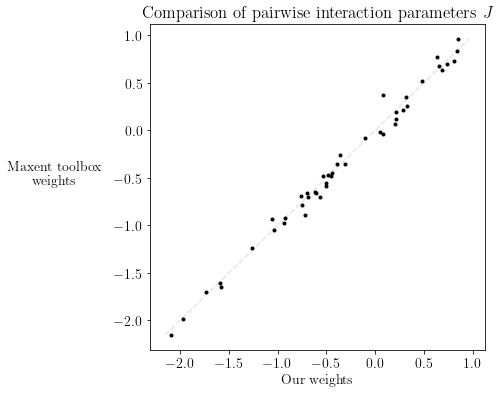

In [62]:
compare_weights(flat_J,mat_ising[N:],"Comparison of pairwise interaction parameters $J$")

In [63]:
p_states = ising.p(np.flip(ising.states, 1))

In [64]:
mat_states= np.loadtxt("../data/pop/m_pwise_dist.csv", delimiter=",", dtype=float)

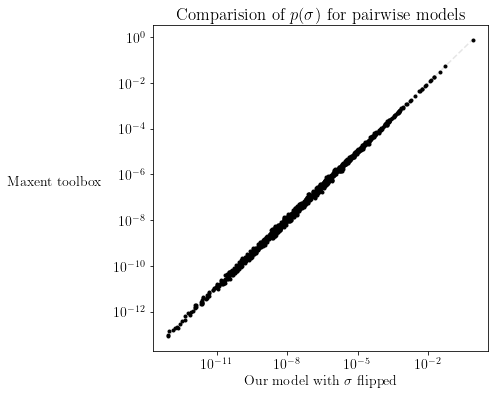

In [65]:
compare_dist(p_states,mat_states, xlab="Our model with $\sigma$ flipped", ylab="Maxent toolbox", title="Comparision of $p(\sigma)$ for pairwise models")